In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-18 11:34:07.653730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 11:34:07.653809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 11:34:07.655466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!cd /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray && tree -d -f -L 2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


.
|-- ./test
|   |-- ./test/NORMAL
|   `-- ./test/PNEUMONIA
|-- ./train
|   |-- ./train/NORMAL
|   `-- ./train/PNEUMONIA
`-- ./val
    |-- ./val/NORMAL
    `-- ./val/PNEUMONIA

9 directories


In [3]:
# declaring paths for image directories

dir_path = "../input/chest-xray-pneumonia/chest_xray/"
train_p = os.path.join(dir_path, "train")
test_p =os.path.join(dir_path, "test")
val_p = os.path.join(dir_path, "val")
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [4]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])

In [5]:
df

,class
0,0
1,0
2,0
3,0
4,0
...,...
5211,1
5212,1
5213,1
5214,1


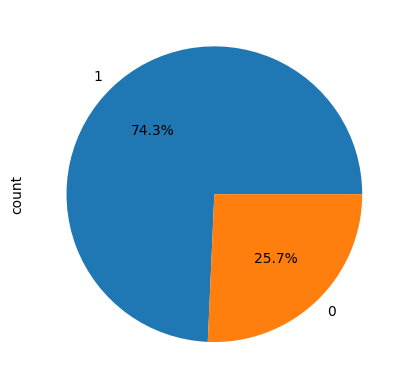

In [6]:
#pie chart of the data
fig, ax = plt.subplots()
df['class'].value_counts().plot(ax=ax, kind='pie', autopct='%1.1f%%')
plt.show()


In [7]:
train_ds = ImageDataGenerator(rescale =1/255,
                              shear_range=10,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              width_shift_range=0.2,
                              fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
    rescale = 1/255
)

Model Design


In [8]:
base_model=VGG16(include_top=False, weights=None,input_shape=(224,224,3), pooling='avg',classes=2)

In [11]:
base_model.load_weights("../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

<Functional name=vgg16, built=True>

In [12]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=0.3,
    zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [18]:
Train = train_gen.flow_from_directory(
    "../input/chest-xray-pneumonia/chest_xray/train",batch_size=16,
    target_size=(224, 224),#class_mode="binary" 
)
val = train_gen.flow_from_directory(
    "../input/chest-xray-pneumonia/chest_xray/test",batch_size=8,
    target_size=(224, 224),#class_mode="binary" 
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
model=Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

## Freezing the layers
for layer in base_model.layers:
    layer.trainable=False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with the defined callback
history = model.fit(Train, epochs=20, validation_data=val, steps_per_epoch=50, callbacks=[early_stopping_cb])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7346 - loss: 0.5558

In [ ]:
accuracy = model.evaluate_generator(test_ds,624)[1]

In [ ]:
accuracy